This notebook introduces the [DynaPicker](https://doi.org/10.48550/arXiv.2211.09539) model. It explains how to load the pretrained model and apply it to generate discrete picks, and how to retrain the model.

In [1]:
#import sys
#sys.path.insert(0, '..')
import os
import numpy as np
import pandas as pd
import torch
from saipy.utils.picktools import *
from saipy.utils.visualizations import *
from saipy.models.dynapicker import *
import h5py

### $(1)$ Loading pre-trained model

In [3]:
%load_ext autoreload
%autoreload 2
model_path = '../saipy/saved_models/'
model = load_dynapicker(model_path)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device: ",device)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Device:  cpu


/home/seismoai/data/GNSS_Chile_Syn/SAIPy_tests/SAIPy_venv/lib/python3.8/site-packages/torch/cuda/__init__.py:138: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11020). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


### $(2)$ Phase-picking using pre-trained model

plotting parameters 

In [4]:
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
font_size = 14
params = {
    'legend.fontsize': font_size,
    'axes.labelsize': font_size,
    'axes.titlesize': font_size,
    'xtick.labelsize':font_size,
    'ytick.labelsize':font_size
}
plt.rcParams.update(params)

### $(\mathrm{ii})$ An example using STEAD dataset

In [5]:
%load_ext autoreload
%autoreload 2
from saipy.data.base import STEAD
stead = STEAD('/home/seismoai/data')
metadata,waveform = stead.get_dynapicker_data()

torch.cuda.empty_cache()

# trace selection
df = metadata[(metadata.trace_category == 'earthquake_local')]
ev_list = df['trace_name'].to_list()[10:11]

evi = ev_list[0]
dataset = waveform.get('data/'+str(evi)) 
# hdf5 dataset into obspy.stream
stream = make_stream_stead(dataset) 
prob_p,prob_s, pwave, swave = phase_picking(device, model, stream, bandpass_filter_flag=True, picker_num_shift=10,
                                            batch_size=4, fremin=1, fremax=40, fo=5, fs=100)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


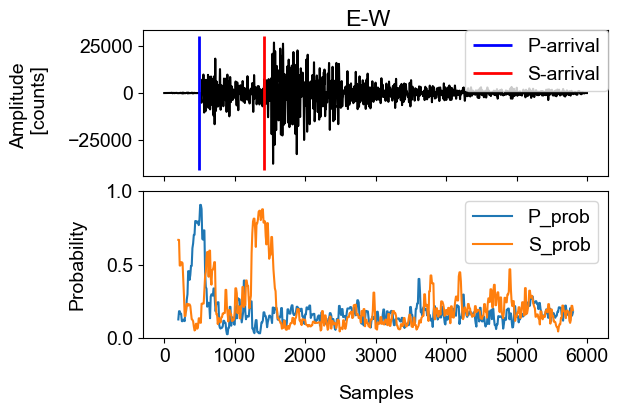

In [6]:
%load_ext autoreload
%autoreload 2
fig = plot_dynapicker_stead(stream, dataset, prob_p, prob_s, picker_num_shift=10, figure_size=(6,4), index=0)
# using fig.savefig('..') to save the figure

### $(\mathrm{iii})$ An example using INSTANCE dataset

In [7]:
%load_ext autoreload
%autoreload 2
from saipy.data.base import INSTANCE
instance = INSTANCE('/home/seismoai/data')
instance_metadata, instance_waveform = instance.get_dynapicker_data(event_type='EQ')

torch.cuda.empty_cache()

wftype='ev_c'
line = 1000
df = instance_metadata
h5 = instance_waveform
stream, row = make_stream_instance(df, h5, line, wftype)
prob_p, prob_s, pwave, swave = phase_picking(device, model, stream, bandpass_filter_flag=True, 
                                             picker_num_shift=10, batch_size=4, fremin=1, fremax=40, 
                                             fo=5, fs=100)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


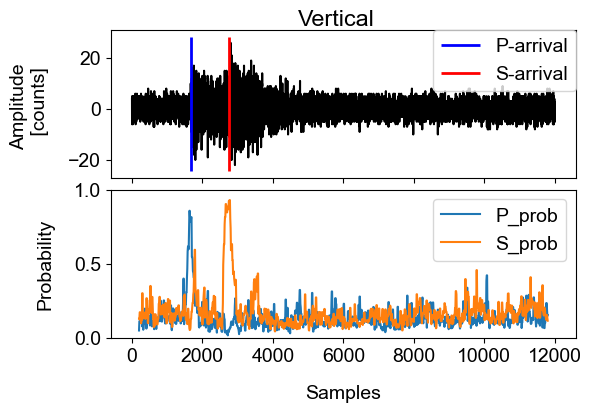

In [8]:
%load_ext autoreload
%autoreload 2
fig = plot_dynapicker_instance(stream, row, prob_p, prob_s, picker_num_shift=10, index=2, figure_size=(6,4))

### $(\mathrm{iv})$ Downloaded Data picking 

dowdloading waveform

In [71]:
from saipy.data.realdata import *

wsp = 'IRIS'
network =  'BC'
station =  'VTX'
location = '*'
channel = "HH*"
time_utc = UTCDateTime("2023-05-02T06:39:45")

stream = waveform_download(wsp=wsp, net=network, sta=station, loc=location, chan=channel, starttime=time_utc, endtime=time_utc+20)

phase picking v1

In [72]:
bandpass_filter =  True
prob_p, prob_s, pwave, swave = phase_picking(device, model, stream, bandpass_filter_flag=True, picker_num_shift=10, batch_size=4, fremin=1, fremax=40, fo=5, fs=100)

visualization v1

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


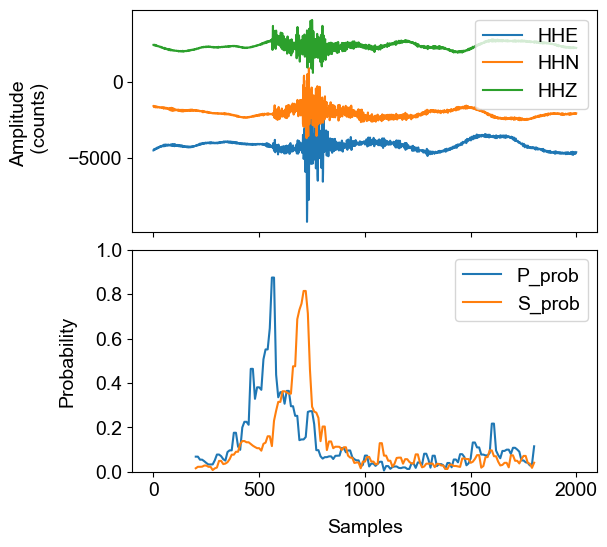

In [73]:
%load_ext autoreload
%autoreload 2
fig = plot_dynapicker_stream(stream, prob_p, prob_s, picker_num_shift=10, figure_size=(6,6))

phase picking v2

In [74]:
preproc_stream, preproc_X = preprocessing(stream,resample_freq=100,freq_min=1,freq_max=45)
prob_p, prob_s, pwave, swave = phase_picking2(device, model, preproc_X, picker_num_shift=10, batch_size=4)

visualization v2

In [84]:
time_utc_dt = time_utc.datetime
starttime_str = time_utc.strftime("%Y-%m-%d %H:%M:%S")
plot_range = np.arange(len(preproc_X))

2023-05-02 06:39:45
<class 'datetime.datetime'>
2023-05-02 06:40:04.990000


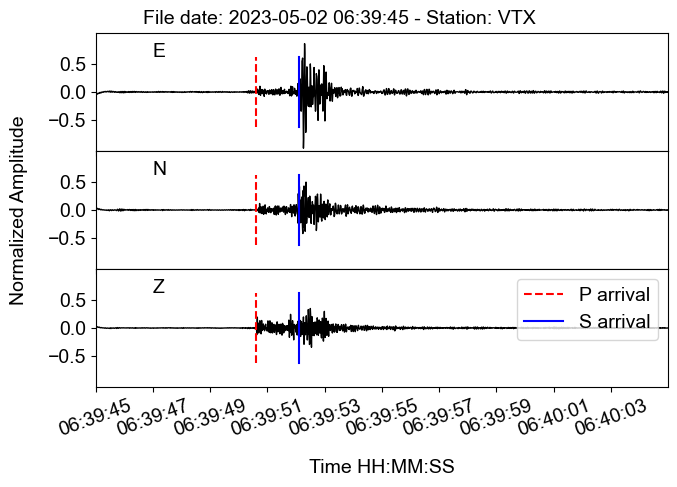

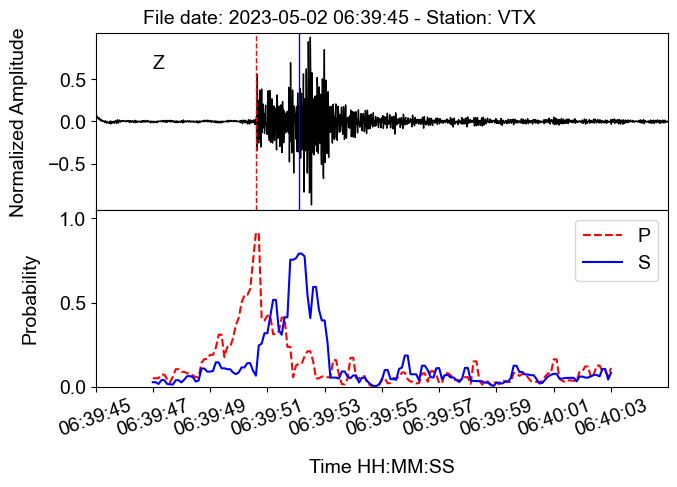

In [85]:
fig1 = plot_data(preproc_X, station, time_utc_dt, starttime_str, samples=plot_range, P_arr=pwave[0], S_arr=swave[0], loc_leg='upper right')
fig2 = plot_dynapicker_output(preproc_X[:,2], station, time_utc_dt, starttime_str, prob_p, prob_s, pwave[0], swave[0], samples=plot_range)
# By default samples=None for X ticks in samples 

### $(3)$ Dynapicker retraining
The following code-blocks show how to retrain dynapciker on invidual 4s-window-format data

### $(\mathrm{i})$ Setting up

In [86]:
%load_ext autoreload
%autoreload 2
from saipy.modules.phaseclassification import *
from saipy.models.dynapicker import *

seed = 24
set_seed(seed) # reproduce
# users can update default values using args.variable_name = new value
args = arguments() 
# loss function
criterion = nn.CrossEntropyLoss()
# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [87]:
print(args)

Namespace(batch_size=3, epochs=20, lr=0.001, model_save_path='./saving_model', num_classes=3, patience=5, verbose=True)


### $(\mathrm{ii})$ Picker retraining

Here, random data is used.

In [88]:
%load_ext autoreload
%autoreload 2


from sklearn.model_selection import train_test_split
num = 120
x = np.random.random_sample((num, 400, 3))
y = np.array([0,1,2]*(int(num/3)))

train_x, rest_x, train_y, rest_y = train_test_split(x, y, train_size=0.8, random_state=seed)
valid_x, test_x, valid_y, test_y = train_test_split(rest_x, rest_y, train_size=0.5, random_state=seed)

train_dataset = CustomDataset(train_x, train_y)
valid_dataset = CustomDataset(valid_x, valid_y)

#dataloder
Train_Loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=args.batch_size, shuffle=True, num_workers=0)

Valid_Loader = torch.utils.data.DataLoader(dataset=valid_dataset, batch_size=args.batch_size, shuffle=False, num_workers=0)
retrained_model, train_loss, valid_loss = train(args, device, Train_Loader, Valid_Loader, criterion, optimizer, scheduler=None)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The directory is created!


  0%|          | 0/20 [00:00<?, ?it/s]

[ 1/20] train_loss: 302.720589 valid_loss: 290.871773
Validation loss decreased (inf --> 290.871773).  Saving model ...


  5%|▌         | 1/20 [00:07<02:21,  7.45s/it]

[ 2/20] train_loss: 291.673780 valid_loss: 257.914227
Validation loss decreased (290.871773 --> 257.914227).  Saving model ...


 10%|█         | 2/20 [00:14<02:05,  7.00s/it]

[ 3/20] train_loss: 330.588047 valid_loss: 252.749329
Validation loss decreased (257.914227 --> 252.749329).  Saving model ...


 20%|██        | 4/20 [00:26<01:45,  6.59s/it]

[ 4/20] train_loss: 295.926273 valid_loss: 256.486473
EarlyStopping counter: 1 out of 5
[ 5/20] train_loss: 304.593857 valid_loss: 245.783621
Validation loss decreased (252.749329 --> 245.783621).  Saving model ...


 30%|███       | 6/20 [00:39<01:30,  6.46s/it]

[ 6/20] train_loss: 299.146404 valid_loss: 248.930145
EarlyStopping counter: 1 out of 5
[ 7/20] train_loss: 290.215148 valid_loss: 242.343702
Validation loss decreased (245.783621 --> 242.343702).  Saving model ...


 40%|████      | 8/20 [00:52<01:17,  6.44s/it]

[ 8/20] train_loss: 317.816177 valid_loss: 260.126537
EarlyStopping counter: 1 out of 5


 45%|████▌     | 9/20 [00:58<01:09,  6.35s/it]

[ 9/20] train_loss: 288.062798 valid_loss: 253.714239
EarlyStopping counter: 2 out of 5


 50%|█████     | 10/20 [01:05<01:02,  6.28s/it]

[10/20] train_loss: 308.179630 valid_loss: 268.179434
EarlyStopping counter: 3 out of 5


 55%|█████▌    | 11/20 [01:11<00:56,  6.24s/it]

[11/20] train_loss: 331.973590 valid_loss: 261.828241
EarlyStopping counter: 4 out of 5


 55%|█████▌    | 11/20 [01:17<01:03,  7.03s/it]

[12/20] train_loss: 317.946898 valid_loss: 256.982517
EarlyStopping counter: 5 out of 5
Early stopping


### $(\mathrm{iii})$ Visualizing the training and valid losses and the early stopping checkpoint

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


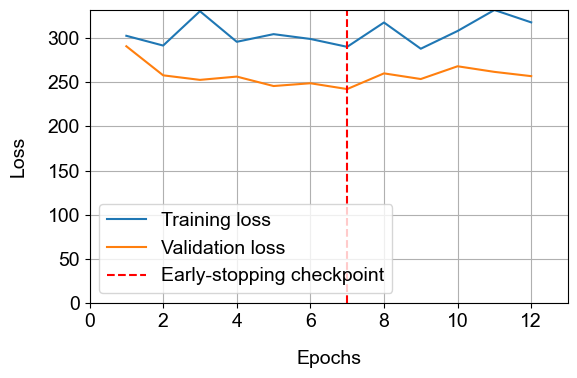

In [89]:
%load_ext autoreload
%autoreload 2
fig= plot_dynapicker_train_history(train_loss, valid_loss, figure_size=(6,4))
fig.savefig('./saving_model/loss.png')

### $(\mathrm{v})$ Model testing

In [90]:
%load_ext autoreload
%autoreload 2

test_dataset = CustomDataset(test_x, test_y)
Test_Loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=args.batch_size,  shuffle=False, num_workers=0)
preds, pred_prob = test(args, device, retrained_model, Test_Loader, criterion)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Test Loss: 231.449474

Test Accuracy of     0:  0% ( 0/ 4)
Test Accuracy of     1:  0% ( 0/ 2)
Test Accuracy of     2: 100% ( 6/ 6)

 Test Accuracy (Overall): 50% ( 6/12)


Confusion matrix plotting

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


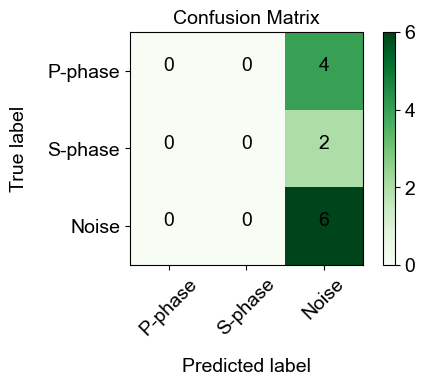

/home/seismoai/data/GNSS_Chile_Syn/SAIPy_tests/SAIPy_venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/seismoai/data/GNSS_Chile_Syn/SAIPy_tests/SAIPy_venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/seismoai/data/GNSS_Chile_Syn/SAIPy_tests/SAIPy_venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to cont

In [91]:
%load_ext autoreload

%autoreload 2
class_labels = ['P-phase', 'S-phase', 'Noise']
fig, metrics_report = plot_dynapicker_confusionmatrix(y_true=test_y, y_pred=preds, label_list=class_labels, digits_num=6, figure_size=(6,4), cmap=plt.cm.Greens)
fig.savefig('./saving_model/cm.png')

metrics report

In [92]:
print("Metrics report \n", metrics_report )

Metrics report 
               precision    recall  f1-score   support

     P-phase   0.000000  0.000000  0.000000         4
     S-phase   0.000000  0.000000  0.000000         2
       Noise   0.500000  1.000000  0.666667         6

    accuracy                       0.500000        12
   macro avg   0.166667  0.333333  0.222222        12
weighted avg   0.250000  0.500000  0.333333        12



Precision_recall curve plotting

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


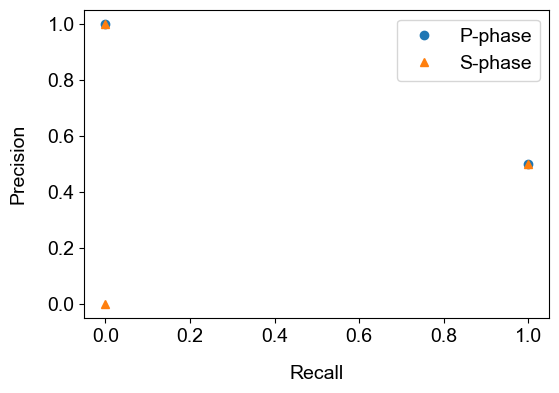

In [93]:
%load_ext autoreload
%autoreload 2
fig = plot_precision_recall_curve(y_true=test_y, y_pred=preds, y_pred_prob=pred_prob, label_list=class_labels, figure_size=(6,4));
## please use fig.savefig() to save the figure in the desired format

ROC curve poltting for multiple classes

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


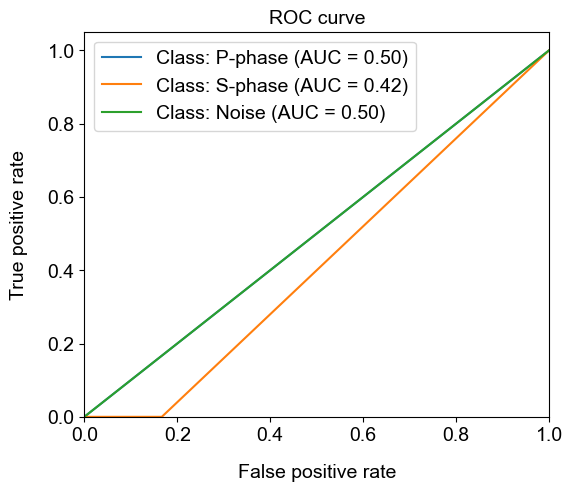

In [94]:
%load_ext autoreload

%autoreload 2
fig = plot_roc_curve(y_true=test_y, y_pred=preds, y_pred_prob=pred_prob, label_list=class_labels, figure_size=(6,5));
fig.savefig('./saving_model/roc_curve.png')